In [1]:
%load_ext autoreload
%autoreload 2

# Prototype anitmations
The purpose of this notebook is to prototype animations for CT-RNNs performing our modular arithmetic task.

## Imports

In [2]:
import json
import os
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize

import jax.numpy as jnp
from jax import random
from flax import linen as nn
from src.model import EulerCTRNNCell
from src.task import SETDataset
from src.training import create_train_state, ModelParameters

from sklearn.decomposition import PCA

from functools import partial

In [3]:
hyperparameter_search = 'experiment_9'
task_id = 'task_180'

params_for_json = f"../results/{hyperparameter_search}/{task_id}/params.json"
example_csv = f"../results/{hyperparameter_search}/{task_id}/metrics_history.csv"
model_params_save = f"../results/{hyperparameter_search}/{task_id}/test_params.bin"

In [4]:
if os.path.exists(params_for_json):
    print(f"{params_for_json} exists.")
else:
    print(f"{params_for_json} does not exist.")

if os.path.exists(example_csv):
    print(f"{example_csv} exists.")
else:
    print(f"{example_csv} does not exist.")

if os.path.exists(model_params_save):
    print(f"{model_params_save} exists.")
else:
    print(f"{model_params_save} does not exist.")

../results/experiment_9/task_180/params.json exists.
../results/experiment_9/task_180/metrics_history.csv exists.
../results/experiment_9/task_180/test_params.bin exists.


## PCA instantiation

In [5]:
with open(params_for_json, 'r') as f:
    json_params = json.load(f)

seed = json_params.get('seed', 0)
alpha = json_params.get('alpha', 0.1)
grok = json_params.get('grok', 0)
grok_label = json_params.get('grok_label', None)
corrupt = json_params.get('corrupt', 0)
min_samples = json_params.get('min_samples', 30)
test_samples = json_params.get('test_samples', 5)
batch_size = json_params.get('batch_size', 108)
lr = json_params.get('lr', 0.001)
norm_clip = json_params.get('norm_clip', 1.0)
epochs = json_params.get('epochs', 500)

key = random.PRNGKey(seed)

In [6]:
key, subkey = random.split(key)
set_dataset = SETDataset(subkey, min_samples, test_samples, batch_size)
set_dataset.grok_SET(grok, grok_label)
set_dataset.corrupt_SET(corrupt)
set_dataset.print_training_testing()
training_tf_dataset, testing_tf_dataset, grok_tf_dataset, corrupt_tf_dataset = set_dataset.tf_datasets()


TRAINING DATA

Accepting Grid:
SET_combinations | Number of Trials | Status
GGG | 100 | 
GPR | 100 | 
GRP | 100 | 
PGR | 100 | 
PPP | 100 | 
PRG | 100 | 
RGP | 100 | 
RPG | 100 | 
RRR | 100 | 

Rejecting Grid:
SET_combinations | Number of Trials | Status
GGP | 50 | 
GGR | 50 | 
GPG | 50 | 
GPP | 50 | 
GRG | 50 | 
GRR | 50 | 
PGG | 50 | 
PGP | 50 | 
PPG | 50 | 
PPR | 50 | 
PRP | 50 | 
PRR | 50 | 
RGG | 50 | 
RGR | 50 | 
RPP | 50 | 
RPR | 50 | 
RRG | 50 | 
RRP | 50 | 

----------

TESTING DATA

Accepting Grid:
SET_combinations | Number of Trials | Status
GGG | 1 | 
GPR | 1 | 
GRP | 1 | 
PGR | 1 | 
PPP | 1 | 
PRG | 1 | 
RGP | 1 | 
RPG | 1 | 
RRR | 1 | 

Rejecting Grid:
SET_combinations | Number of Trials | Status
GGP | 1 | 
GGR | 1 | 
GPG | 1 | 
GPP | 1 | 
GRG | 1 | 
GRR | 1 | 
PGG | 1 | 
PGP | 1 | 
PPG | 1 | 
PPR | 1 | 
PRP | 1 | 
PRR | 1 | 
RGG | 1 | 
RGR | 1 | 
RPP | 1 | 
RPR | 1 | 
RRG | 1 | 
RRP | 1 | 

----------

GROK DATA

Accepting Grid:
SET_combinations | Number of Trials | Sta

In [7]:
features = 100
alpha = jnp.float32(alpha) # json_param alpha
noise = jnp.float32(0.1)

ctrnn = nn.RNN(EulerCTRNNCell(features=features, alpha=alpha, noise=noise,))

key, subkey = random.split(key)
state = create_train_state(ctrnn, subkey, lr, norm_clip,)

model_params = ModelParameters(state)
model_params.deserialize(model_params_save,)

In [8]:
inputs_list = []
labels_list = []
rates_list = []
outputs_list = []

for _inputs, _labels in tqdm(training_tf_dataset.as_numpy_iterator()):
    key, subkey = random.split(key)
    _outputs, _rates = ctrnn.apply(model_params.params, _inputs, init_key=subkey,)

    inputs_list.append(_inputs)
    labels_list.append(_labels)
    rates_list.append(_rates)
    outputs_list.append(_outputs)

inputs_ = jnp.concatenate(inputs_list, axis=0)
labels_ = jnp.concatenate(labels_list, axis=0)
rates_ = jnp.concatenate(rates_list, axis=0)
outputs_ = jnp.concatenate(outputs_list, axis=0)

rates_reshaped = rates_.reshape(-1, rates_.shape[-1])

pca = PCA(n_components=3)
pca.fit(rates_reshaped)

14it [00:02,  5.26it/s]2024-04-18 00:02:58.428537: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



PCA(n_components=3)

## Static plot development

In [9]:
# Create trial
(input_array, output_array) = set_dataset.create_trial('GPR', 3)

key, subkey = random.split(key)
trial_outputs, trial_rates = ctrnn.apply(model_params.params, jnp.expand_dims(input_array, axis=0), init_key=subkey,)

trial_rates_pc = pca.transform(trial_rates[0])
trial_rates_pc.shape

(50, 3)

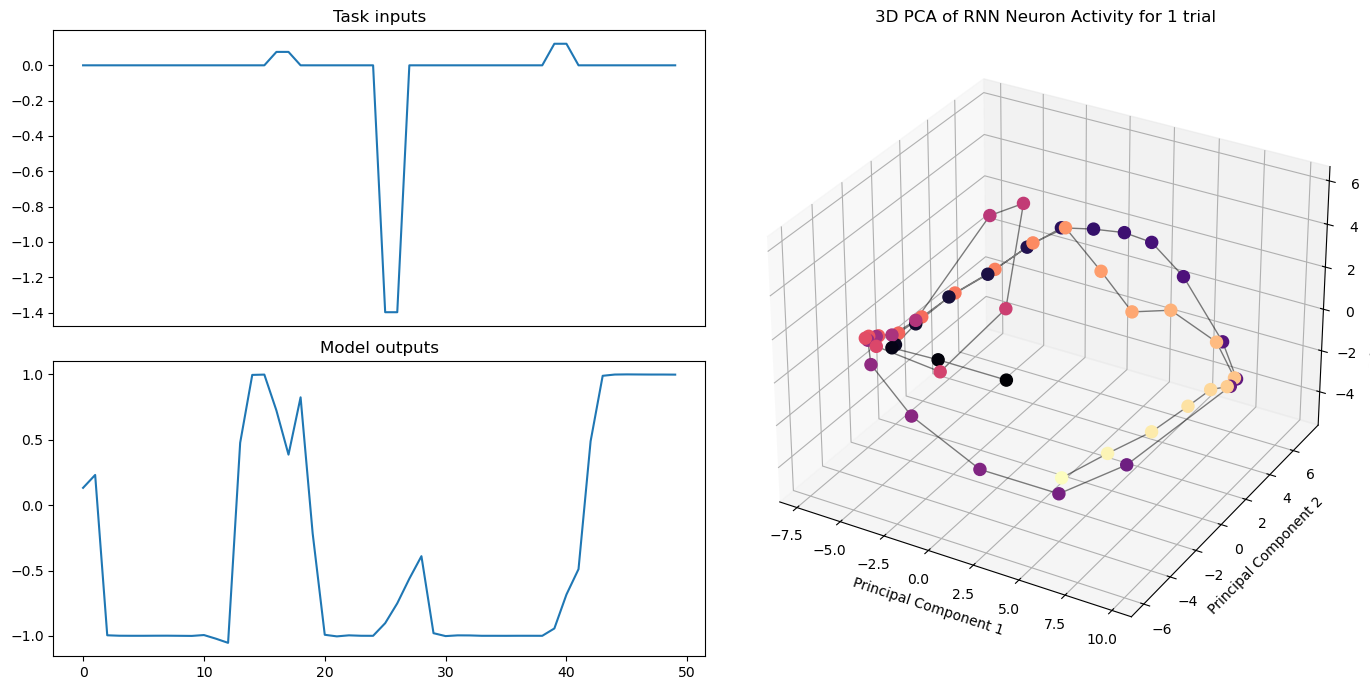

In [10]:
fig = plt.figure(figsize=(14, 7))
gs = GridSpec(2, 2)

# Panel 1: Task Inputs
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(input_array[:, :1])
ax1.set_title('Task inputs')
ax1.set_xticks([])

# Panel 2: Model Outputs
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(trial_outputs[0, :, :3])
ax2.set_title('Model outputs')

# Panel 4: 3D PCA of RNN Neuron Activity
ax4 = fig.add_subplot(gs[:, 1], projection='3d')

x, y, z = trial_rates_pc[:,0], trial_rates_pc[:,1], trial_rates_pc[:,2]

ax4.plot(x, y, z, color='black', linewidth=1, alpha=0.5)
sc = ax4.scatter(x, y, z, c=jnp.arange(trial_rates_pc.shape[0]), cmap='magma', depthshade=False, s=75)

ax4.set_xlim([x.min()-0.5, x.max()+0.5])
ax4.set_ylim([y.min()-0.5, y.max()+0.5])
ax4.set_zlim([z.min()-0.5, z.max()+0.5])

ax4.set_xlabel('Principal Component 1')
ax4.set_ylabel('Principal Component 2')
ax4.set_zlabel('Principal Component 3')
ax4.set_title('3D PCA of RNN Neuron Activity for 1 trial')

plt.tight_layout()
plt.show()

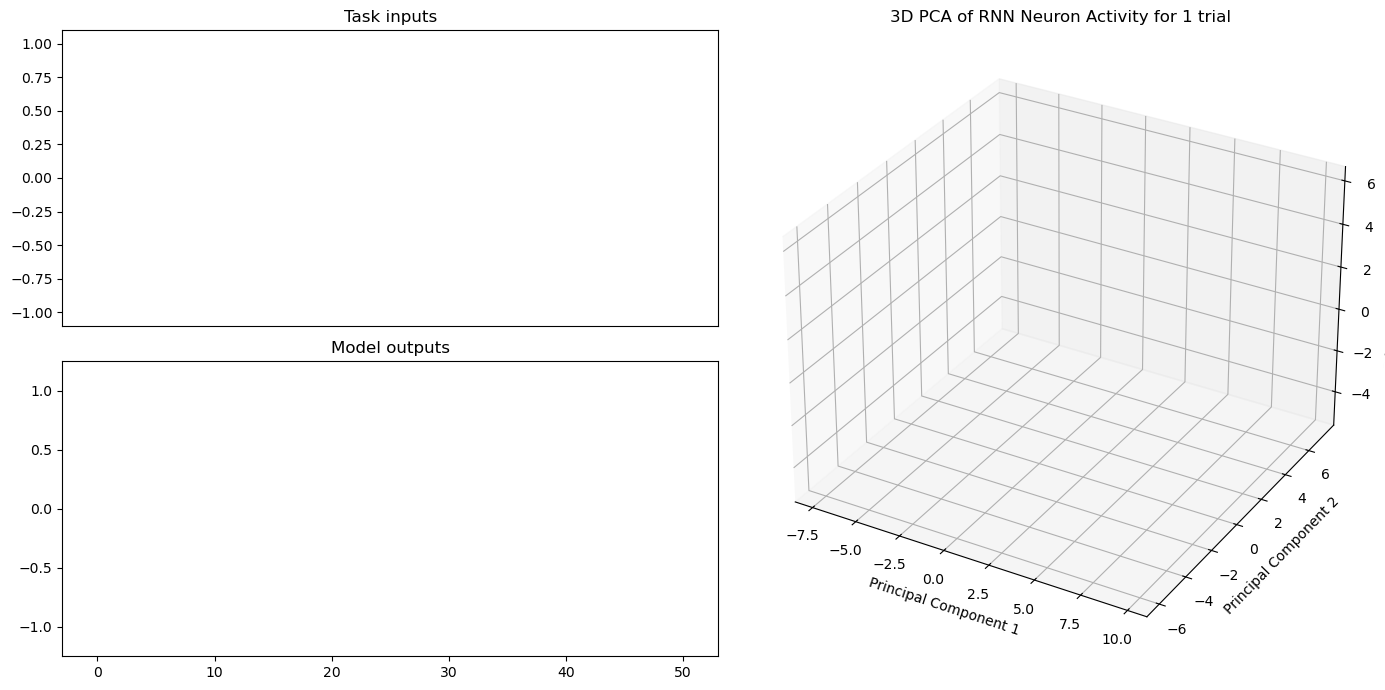

In [11]:
fig = plt.figure(figsize=(14, 7))
gs = GridSpec(2, 2)

# Panel 1: Task Inputs
ax1 = fig.add_subplot(gs[0, 0])
line1_0, = ax1.plot([], [], color='tab:blue')
ax1.set_title('Task inputs')
ax1.set_xticks([])
ax1.set_xlim(-3, 53)
ax1.set_ylim(-1.1, 1.1)

# Panel 2: Model Outputs
ax2 = fig.add_subplot(gs[1, 0])
line2_0, = ax2.plot([], [], color='tab:red')
line2_1, = ax2.plot([], [], color='tab:purple')
line2_2, = ax2.plot([], [], color='tab:green')
ax2.set_title('Model outputs')
ax2.set_xlim(-3, 53)
ax2.set_ylim(-1.25, 1.25)

# Panel 4: 3D PCA of RNN Neuron Activity
norm = Normalize(vmin=0, vmax=trial_rates_pc.shape[0]-1)
cmap = plt.get_cmap('magma')
colors = cmap(norm(jnp.arange(trial_rates_pc.shape[0])))

ax4 = fig.add_subplot(gs[:, 1], projection='3d')

line4 = ax4.plot([], [], [], color='black', linewidth=1, alpha=0.5)
sc = ax4.scatter([], [], [], depthshade=False, s=75)

ax4.set_xlim([x.min()-0.5, x.max()+0.5])
ax4.set_ylim([y.min()-0.5, y.max()+0.5])
ax4.set_zlim([z.min()-0.5, z.max()+0.5])

ax4.set_xlabel('Principal Component 1')
ax4.set_ylabel('Principal Component 2')
ax4.set_zlabel('Principal Component 3')
ax4.set_title('3D PCA of RNN Neuron Activity for 1 trial')

def update(frame):
    # Update each line in all subplots
    line1_0.set_data(jnp.arange(frame), input_array[:frame, :1])
    
    line2_0.set_data(jnp.arange(frame), trial_outputs[0, :frame, 0])

    # Update the 3D line plot
    line4[0].set_data(x[:frame], y[:frame])
    line4[0].set_3d_properties(z[:frame])
    
    sc._offsets3d = (x[:frame], y[:frame], z[:frame])
    sc.set_facecolors(colors[:frame])
    
    return line1_0, line2_0, line2_1, line2_2, line4, sc, 

num_frames = 50
ani = FuncAnimation(fig, update, frames=num_frames, interval=150, blit=False)

plt.tight_layout()
plt.show()

ani.save('rnn_pca_activity.mp4', writer='ffmpeg')